# A simple demo of reparameterizing the gamma distribution

First, check out our blog post for the complete scoop. Once you've read that, the 
functions below will make sense.  

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.special import gammaln, psi
from autograd import grad
from autograd.optimizers import adam, sgd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
%matplotlib inline

npr.seed(1)

In [2]:
# theta are the unconstrained parameters
def unwrap(theta):
    alpha = np.exp(theta[0]) + 1
    beta = np.exp(theta[1])
    return alpha, beta

def wrap(alpha, beta):
    return np.array([np.log(alpha-1), np.log(beta)])

# Log density of Ga(alpha, beta)
def log_q(z, theta):
    alpha, beta = unwrap(theta)
    return -gammaln(alpha) + alpha * np.log(beta) \
           + (alpha - 1) * np.log(z) - beta * z

# Log density of N(0, 1)
def log_s(epsilon):
    return -0.5 * np.log(2*np.pi) -0.5 * epsilon**2

# Transformation and its derivative
def h(epsilon, theta):
    alpha, beta = unwrap(theta)
    return (alpha - 1./3.) * (1 + epsilon/np.sqrt(9*alpha-3))**3 / beta

def dh(epsilon, theta): 
    alpha, beta = unwrap(theta)
    return (alpha - 1./3) * 3./np.sqrt(9*alpha - 3.) * \
           (1+epsilon/np.sqrt(9*alpha-3))**2 / beta

# Log density of proposal r(z) = s(epsilon) * |dh/depsilon|^{-1}
def log_r(epsilon, theta): 
    return -np.log(dh(epsilon, theta)) + log_s(epsilon)

# Density of the accepted value of epsilon 
# (this is just a change of variables too)
def log_pi(epsilon, theta):
    return log_s(epsilon) + \
           log_q(h(epsilon, theta), theta) - \
           log_r(epsilon, theta)

In [3]:
# To compute expectations with respect to pi, 
# we need to be able to sample from it.  
# This is simple -- sample a gamma and pass it 
# through h^{-1} 
def h_inverse(z, theta):
    alpha, beta = unwrap(theta)
    return np.sqrt(9.0 * alpha - 3) * ((beta * z / (alpha - 1./3))**(1./3) - 1)

def sample_pi(theta, size=(1,)):
    alpha, beta = unwrap(theta)
    return h_inverse(npr.gamma(alpha, 1./beta, size=size), theta)

# Test
z = 2.0
th = npr.randn(2)
assert np.allclose(h_inverse(h(z, th), th), z)

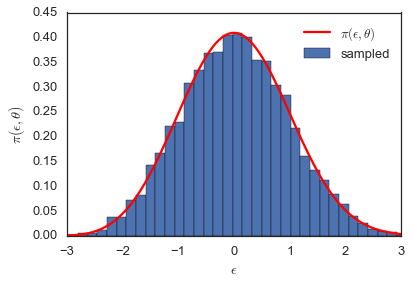

In [4]:
# Plot the acceptance probability in epsilon space
eps = np.linspace(-3,3,100)
th = npr.randn(2)
alpha, beta = unwrap(th)
eps_samples = sample_pi(th, 10000)


plt.plot(eps, np.exp(log_pi(eps, th)), 'r', label="$\pi(\epsilon, \\theta)$")
plt.hist(eps_samples, 40, normed=True, label="sampled")

plt.xlim(-3, 3)
plt.xlabel("$\epsilon$")
plt.ylabel("$\pi(\epsilon, \\theta)$")
plt.legend(loc="upper right")

# Define a simple observation model
In this case, we'll use a Poisson observation model with
a true rate of $z = 3.0$

In [5]:
z_true = 3.0
a0, b0 = 1.0, 1.0
N = 10
x = npr.poisson(z_true, size=N)

# Define the Poisson log likelihood
def log_p(x, z):
    x = np.atleast_1d(x)
    z = np.atleast_1d(z)
    lp = -gammaln(a0) + a0 * np.log(b0) \
         + (a0 - 1) * np.log(z) - b0 * z
    ll = np.sum(-gammaln(x[:,None]+1) - z[None,:] 
                + x[:,None] * np.log(z[None, :]),
                axis=0)
    return lp + ll
    
# We can compute the true posterior in closed form
alpha_true = a0 + x.sum()
beta_true = b0 + N


We need the gamma entropy too...

In [6]:
def gamma_entropy(theta):
    alpha, beta = unwrap(theta)
    return alpha - np.log(beta) + gammaln(alpha) + (1-alpha) * psi(alpha)

# Now use autograd to compute necessary gradients

In [7]:
def reparam_objective(epsilon, theta):
    return np.mean(log_p(x, h(epsilon, theta)), axis=0)

def score_objective(epsilon, theta):
    # unbox the score so that we don't take gradients through it
    score = log_p(x, h(epsilon, theta)).value
    return np.mean(score * log_pi(epsilon, theta), axis=0)
    
g_reparam = grad(reparam_objective, argnum=1)
g_score = grad(score_objective, argnum=1)
g_entropy = grad(gamma_entropy)

def elbo(theta, N_samples=10):
    epsilon = sample_pi(theta, size=(N_samples,))
    return np.mean(log_p(x, h(epsilon, theta))) + gamma_entropy(theta)

def g_elbo(theta, N_samples=10):
    epsilon = sample_pi(theta, size=(N_samples,))
    return g_reparam(epsilon, theta) \
           + g_score(epsilon, theta) \
           + g_entropy(theta)
    

# Optimize ELBO with SGD

true a =  34.0
infd a =  29.7580526784
true b =  11.0
infd b =  9.94980782236
E_q(z; theta)[z] =  2.9908168288


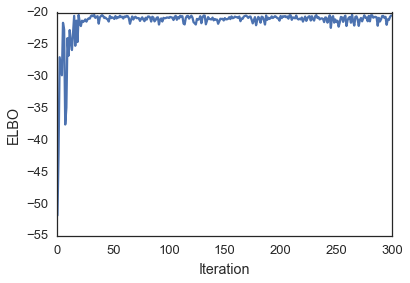

In [8]:
elbo_values = []
def callback(theta, t, g):
    elbo_values.append(elbo(theta))
    
theta_0 = wrap(2.0, 2.0)
theta_star = sgd(lambda th, t: -1 * g_elbo(th), 
                 theta_0, num_iters=300, callback=callback)

alpha_star, beta_star = unwrap(theta_star)
print("true a = ", alpha_true)
print("infd a = ", alpha_star)
print("true b = ", beta_true)
print("infd b = ", beta_star)
print("E_q(z; theta)[z] = ", alpha_star/beta_star)

plt.plot(elbo_values)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

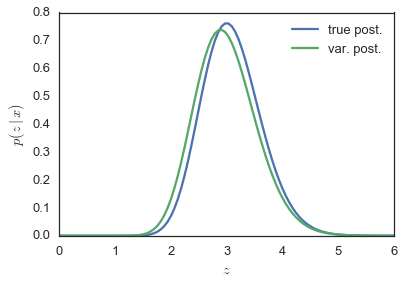

In [9]:
import scipy.stats
zs = np.linspace(0,6,100)
plt.plot(zs, scipy.stats.gamma(alpha_true, scale=1./beta_true).pdf(zs), label="true post.")
plt.plot(zs, scipy.stats.gamma(alpha_star, scale=1./beta_star).pdf(zs), label="var. post.")
plt.legend(loc="upper right")
plt.xlabel("$z$")
plt.ylabel("$p(z \\mid x)$")